In [1]:
# パッケージのインストール（初回のみ実行）
using Pkg
Pkg.activate(".")  # 現在のディレクトリの環境をアクティブ化
#Pkg.add("ITensors")  # ITensorsパッケージをインストール

  Activating project at `c:\Users\ito23\Documents\学院科目\物性物理学特論Ⅰ\Julia\day4\Mypackage`


In [2]:
using ITensors
using Plots
using LaTeXStrings

In [3]:
# 規格化テンソルの作成
function normalize_tensor(T::ITensor)
    normalize_T = T / norm(T)

    return normalize_T
end

normalize_tensor (generic function with 1 method)

In [8]:
# 原始テンソルの生成(固定端)
function tensor_origin_fix(K::Float64)
    i = Index(2, "i")
    j = Index(2, "j")
    k = Index(2, "k")
    l = Index(2, "l")
    W = ITensor(i, j, k, l)
    
    for ll in 0:1, kk in 0:1, jj in 0:1, ii in 0:1
        W[i => ii+1, j => jj+1, k => kk+1, l => ll+1] = exp(K * ((2 * ii - 1) * (2 * jj - 1) + (2 * jj - 1) * (2 * kk - 1) + (2 * kk - 1) * (2 * ll - 1) + (2 * ll - 1) * (2 * ii - 1)))
    end

    del_l = ITensor(l)
    del_l[l => 2] = 1.0

    P = W * del_l

    del_k = ITensor(k)
    del_k[k => 2] = 1.0

    C = P * del_k

    W = normalize_tensor(W)
    P = normalize_tensor(P)
    C = normalize_tensor(C)

    return W, P, C
end

tensor_origin_fix (generic function with 1 method)

In [9]:
# Pの拡大
function expand_tensor_3legs(W::ITensor, P::ITensor)
    i, j, k, l = inds(W)
    inds_P = inds(P)
    n = dim(inds_P[1])

    p = Index(n, "p")
    q = Index(n, "q")

    inds_new_P = [p, l, q]

    P = replaceinds(P, inds_P, inds_new_P)

    P = P * W

    P = combiner(i, p; tags="x") * P * combiner(k, q; tags="y")

    P = normalize_tensor(P)

    return P
end

expand_tensor_3legs (generic function with 1 method)

In [10]:
# Cの拡大
function expand_tensor_2legs(W::ITensor, P::ITensor, C::ITensor)
    i, j, k, l = inds(W)
    inds_P = inds(P)
    inds_C = inds(C)
    n = dim(inds_P[1])

    p = Index(n, "p")
    q = Index(n, "q")
    r = Index(n, "r")
    s = Index(n, "s")

    inds_new_P_L = [p, l, q]
    inds_new_P_R = [r, k, s]
    inds_new_C = [q, r]

    P_b_L = replaceinds(P, inds_P, inds_new_P_L)
    P_b_R = replaceinds(P, inds_P, inds_new_P_R)
    C = replaceinds(C, inds_C, inds_new_C)

    C = P_b_L * C * P_b_R * W

    C = combiner(i, p; tags="z") * C * combiner(j, s; tags="w")

    C = normalize_tensor(C)

    return C
end

expand_tensor_2legs (generic function with 1 method)

In [11]:
# 対角化
function diagonalize_tensor(C::ITensor)
    z, w = inds(C)

    D, U = eigen(C, z, w)
    D = real(D)
    U = real(U)

    return D, U
end

diagonalize_tensor (generic function with 1 method)

In [18]:
# 圧縮
function compress_tensor(C::ITensor, P::ITensor, chi::Int64)
    D, U = diagonalize_tensor(C)

    n = dim(inds(C)[1])
    
    p = Index(chi, "p")
    q = Index(chi, "q")

    C = ITensor(p, q)

    for jj in 1:chi, ii in 1:chi
        C[p => ii, q => jj] = D[inds(D)[1] => n - chi + ii, inds(D)[2] => n - chi + jj]
    end

    # C = normalize_tensor(C)

    inds_U = inds(U)
    U = normalize_tensor(U)

    u = Index(dim(inds(U)[1]), "u")
    v = Index(chi, "v")
    
    U_compressed = ITensor(u, v)

    for jj in 1:chi, ii in 1:n
        U_compressed[u => ii, v => jj] = U[inds_U[1] => ii, inds_U[2] => n - chi + jj]
    end

    inds_U_compressed = inds(U_compressed)
    inds_P = inds(P)
    n_u = dim(inds_U_compressed[1])
    m_u = dim(inds_U_compressed[2])

    a = Index(n_u, "a")
    b = Index(m_u, "b")
    c = Index(n_u, "c")
    d = Index(m_u, "d")
    e = Index(dim(inds_P[2]), "e")

    inds_new_U_compressed_l = [a, b]
    inds_new_U_compressed_r = [c, d]
    inds_new_P = [a, e, c]

    U_compressed_l = replaceinds(U_compressed, inds_U_compressed, inds_new_U_compressed_l)
    U_compressed_r = replaceinds(U_compressed, inds_U_compressed, inds_new_U_compressed_r)
    P = replaceinds(P, inds_P, inds_new_P)

    P = U_compressed_l * P * U_compressed_r

    # P = normalize_tensor(P)
    
    return C, P
end

compress_tensor (generic function with 1 method)

In [14]:
# 環境テンソルの生成
function environment_tensor(W::ITensor, P::ITensor, C::ITensor)
    i, j, k, l = inds(W)
    inds_P = inds(P)
    inds_C = inds(C)
    n = dim(inds_P[1])

    g_la = Index(n, "g_la")
    g_lb = Index(n, "g_lb")
    g_al = Index(n, "g_al")
    g_ar = Index(n, "g_br")
    g_ra = Index(n, "g_ra")
    g_rb = Index(n, "g_rb")
    g_br = Index(n, "g_br")
    g_bl = Index(n, "g_bl")

    inds_new_P_l = [g_la, i, g_lb]
    inds_new_P_a = [g_ar, j, g_al]
    inds_new_P_r = [g_rb, k, g_ra]
    inds_new_P_b = [g_bl, l, g_br]
    inds_new_C_al = [g_al, g_la]
    inds_new_C_ar = [g_ra, g_ar]
    inds_new_C_br = [g_br, g_rb]
    inds_new_C_bl = [g_lb, g_bl]

    P_l = replaceinds(P, inds_P, inds_new_P_l)
    P_a = replaceinds(P, inds_P, inds_new_P_a)
    P_r = replaceinds(P, inds_P, inds_new_P_r)
    P_b = replaceinds(P, inds_P, inds_new_P_b)
    C_al = replaceinds(C, inds_C, inds_new_C_al)
    C_ar = replaceinds(C, inds_C, inds_new_C_ar)
    C_br = replaceinds(C, inds_C, inds_new_C_br)
    C_bl = replaceinds(C, inds_C, inds_new_C_bl)

    G = C_al * P_a * C_ar * P_r * C_br * P_b * C_bl * P_l

    O = G * W

    return G, O
end

environment_tensor (generic function with 1 method)

In [15]:
# スピン相関の測定
function measure_spin_correlation(W::ITensor, G::ITensor, O::ITensor)
    i, j, k, l = inds(W)
    a = Index(2, "a")
    b = Index(2, "b")

    W = replaceinds(W, [i, l] => [a, b])

    S_l = ITensor(i, a)
    S_b = ITensor(l, b)
    
    for ii in 1:2
        S_l[i => ii, a => ii] = 2 * ii - 3
        S_b[l => ii, b => ii] = 2 * ii - 3
    end

    O_s = S_l * S_b * G * W

    SS_ev = only(O_s / O)

    return SS_ev
end

measure_spin_correlation (generic function with 1 method)

In [16]:
# 自発磁化の測定
function measure_magnetization(W::ITensor, G::ITensor, O::ITensor)
    i, j, k, l = inds(W)
    a = Index(2, "a")

    W = replaceinds(W, [i] => [a])

    S = ITensor(i, a)
    
    for ii in 1:2
        S[i => ii, a => ii] = 2 * ii - 3
    end

    O_s = S * G * W

    M_ev = only(O_s / O)

    return M_ev
end

measure_magnetization (generic function with 1 method)

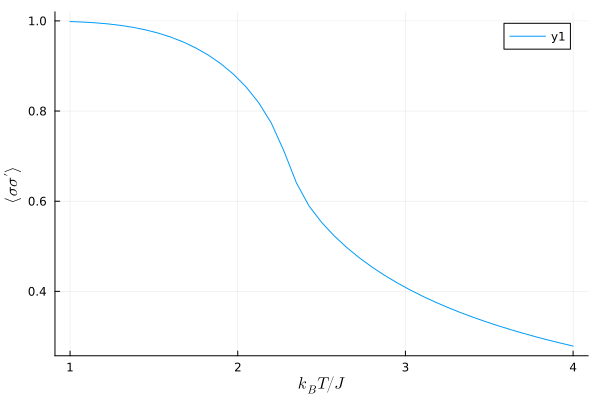

In [26]:
# メイン

# 定数の定義
J = 1.0
k_B = 1.0
T_C = 2.0 / log(1 + sqrt(2))
T = range(1.0, 4.0, length = 41)
K_C = J / k_B / T_C
K = J ./ k_B ./ T
L = 20
chi = 200
Ls = [1]
m = []
mm = []

# 計算

for Ks in K
    W, P, C = tensor_origin_fix(Ks)

    for LL in 2:L
        # 拡大
        C = expand_tensor_2legs(W, P, C)
        P = expand_tensor_3legs(W, P)

        # 圧縮
        if 2^LL > chi
            C, P = compress_tensor(C, P, chi)
        end
    end

    # 測定
    G, O = environment_tensor(W, P, C)
    push!(mm, measure_spin_correlation(W, G, O))

    # メモリの解法
    GC.gc()
end

plot(T, mm, xlabel = L"k_BT/J", ylabel = L"\langle\sigma\sigma^\prime\rangle", title = "")

In [12]:
GC.gc()

In [ ]:
# メイン

# 定数の定義
J = 1.0
k_B = 1.0
T_C = 2.0 / log(1 + sqrt(2))
T = range(1.0, 4.0, length = 41)
K_C = J / k_B / T_C
K = J ./ k_B ./ T
L = 73
chi = 5
Ls = []
m = []
mm = []

# 計算

#for Ks in K
    W, P, C = tensor_origin_fix(K_C)

    for LL in 2:L
        # 拡大
        C = expand_tensor_2legs(W, P, C)
        P = expand_tensor_3legs(W, P)

        # 圧縮
        if 2^LL > chi
            C, P = compress_tensor(C, P, chi)
        end

        # 測定
        G, O = environment_tensor(W, P, C)
        push!(m, measure_magnetization(W, G, O))
        push!(Ls, 2 * LL + 1)

        # メモリの解法
        GC.gc()
    end

#end

xtick_vals = [1, 10, 100, 1000]
xtick_labels = string.(xtick_vals)

ytick_vals = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ytick_labels = string.(ytick_vals)

println(Ls)
plot(Ls, m, xscale=:log10, yscale=:log10, xticks = (xtick_vals, xtick_labels), yticks = (ytick_vals, ytick_labels), xlabel=L"L", ylabel=L"\langle\sigma\rangle", title="")
